In [13]:
from tdavec import createEllipse, TDAvectorizer, tdavec_core
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

## Data Set 

Let us create some set of squezzed ellipses:

In [14]:
np.random.seed(42)
epsList = np.random.uniform(low = 0, high = 1, size = 500)
np.savetxt("../R/epsList.csv", epsList)
clouds = [createEllipse(a=1, b=eps, n=100) for eps in epsList]

Here are some examples:

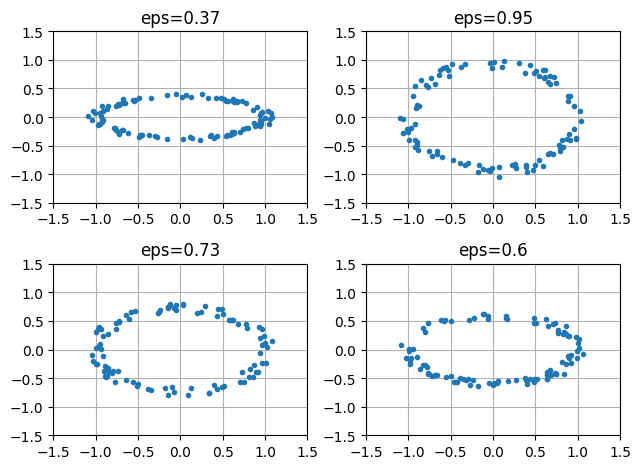

In [25]:
for i, cl in enumerate(clouds[:4]):
    plt.subplot(2, 2, i+1)
    plt.plot(cl[:,0], cl[:,1], ".")
    plt.xlim(-1.5, 1.5); plt.ylim(-1.5, 1.5)
    plt.title(f"eps={np.round(epsList[i], 2)}")
    plt.grid()
plt.tight_layout()

## Pesistance Diagrams and Vectorizations 

In order to perform TDA analysis of the generated clouds we should convert them to Persostence Doagrams and perform vectorization. Both steps can be done using object of **TDAvectorizer** class:

In [27]:
v = TDAvectorizer()
v.setParams({"scale":np.linspace(0, 2, 10)})
v.fit(clouds)

Here are the examples of the generated persistence diagrams:

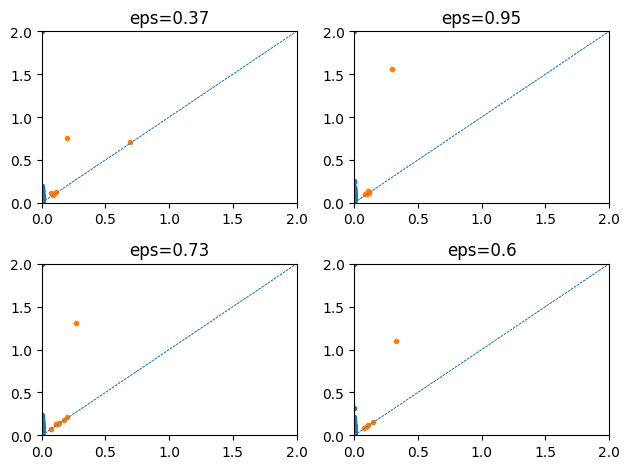

In [28]:
for i in range(4):
    plt.subplot(2,2,i+1)
    PD = v.diags[i]
    for dim in range(2):
        plt.plot(PD[dim][:,0], PD[dim][:,1], ".")
        plt.xlim(0, 2); plt.ylim(0, 2)
        plt.axline( (0,0), slope = 1, linestyle = "--", linewidth = 0.5)
        plt.title(f"eps={np.round(epsList[i], 2)}")
plt.tight_layout()

Here are some PS plots

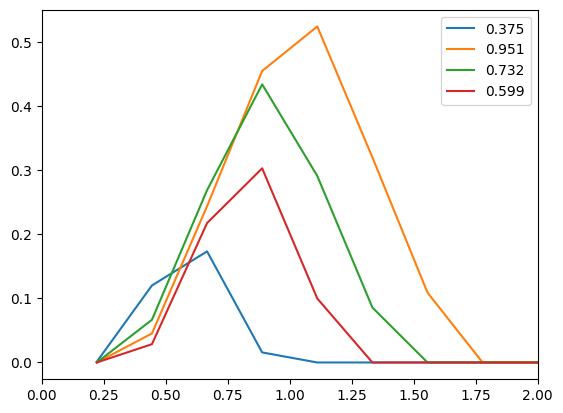

In [29]:
X = v.transform(output="PS", homDim=1)
for i, e in enumerate(epsList[:4]):
    plt.plot(v.getParams()["scale"][1:],X[i,:], label=np.round(e, 3))
    plt.xlim(0, 2)
plt.legend()
plt.show()

## Machine Learning

Let us now solve a ML problem and predict squze ratio from the TDA infformation.

In our analysis we will check diferent vectorizations

Here is a function that uses specified vectorization method to solve the regression task and guess the squese factor:

In [30]:
v.setParams({"scale":np.linspace(0, 2, 30)})
methodList = v.vectorization_names
def makeSim(X, y=epsList):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, random_state=42)
    model = LinearRegression().fit(Xtrain, ytrain)
    test_preds = model.predict(Xtest)
    score = model.score(Xtest, ytest)
    res = {"method":method, "homDim":homDim, "test_preds":test_preds, "y_test":ytest, "score":score}
    return res

In the loop below we collect performace statistics for different vectorization methods:

In [31]:
results = []
df = pd.DataFrame()
for homDim in [0, 1]:
    print(f" Dimension {homDim}: ", end=" ")
    for method in methodList[:-2]:
        print(method, end = " ")
        X =v.transform(output=method, homDim=homDim)
        res = makeSim(X); results.append(res)
        df = pd.concat([df, pd.DataFrame(res)])
    print()

 Dimension 0:  vab vpb pl ps nl ecc pes pi fda algebra stats poly 
 Dimension 1:  vab vpb pl ps nl ecc pes pi fda algebra stats poly 


Here is the regression scores table for different vetcorizations 

In [32]:
df["homDim"] = df["homDim"].astype("category")
comp_df = df[["method", "homDim", "score"]].drop_duplicates().pivot(index="method", columns="homDim", values="score").round(3)
comp_df.sort_values(1, ascending=False).iloc[:-1]

homDim,0,1
method,,
ecc,0.976,0.996
vab,0.976,0.986
fda,0.983,0.985
nl,0.960,0.981
poly,0.967,0.975
pi,0.985,0.973
algebra,0.971,0.955
pl,-0.008,0.915
ps,0.946,0.914


As you can see, they are very close to 1, so fits are pretty accurate

The same can be easily seen from presented below scatter plots whrere for each dimension and method true and predicted values if the ellipse squese factor are shown on horizontal and vertical axes.

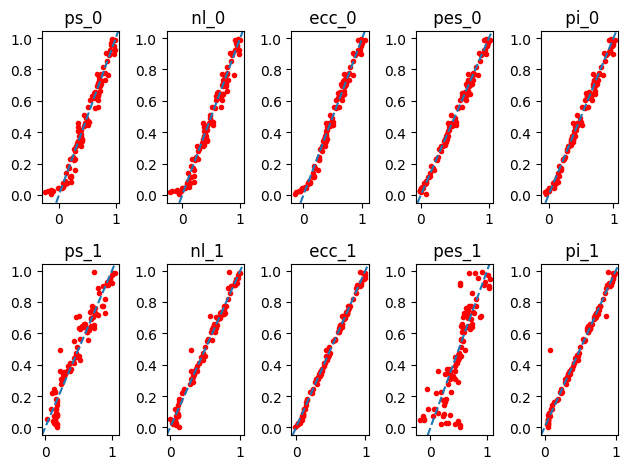

In [33]:
results_ = [r for r in results if r["method"] in methodList[3:8]]
for i, r in enumerate(results_):
    plt.subplot(2, 5, i+1)
    plt.plot(r["test_preds"], r["y_test"], "r.")
    plt.axline( (0,0), slope=1, linestyle = "--")
    plt.title(" {}_{}".format(r["method"], r["homDim"]))
plt.tight_layout()